# 3.0 Prompting

This notebook:
- Initializes the Flan-T5-small model and tokenizer for text generation.
- Implements zero-shot prompting — model classifies reviews without seeing examples.
- Implements few-shot prompting — model is given 4 labeled examples (2 positive, 2 negative) before classification.
- Evaluates model predictions using:
    - Accuracy, Macro F1, and Brier Score
    - Confusion matrices and reliability (calibration) curves

In [5]:
import json
from pathlib import Path
import yaml
import random
import numpy as np
import pandas as pd
import torch
from datasets import load_dataset, concatenate_datasets
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, brier_score_loss, classification_report
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import joblib
import csv

In [6]:
ROOT = Path.cwd().parent
CFG_PATH = ROOT / "configs" / "data.yaml"

with open(CFG_PATH, "r") as f:
    CFG = yaml.safe_load(f)

DIR_SPLITS = ROOT / CFG.get("output_splits", "data/splits")
DIR_TABLES = ROOT / CFG["output_tables"]
DIR_FIGS   = ROOT / CFG["output_figures"]
DIR_PREDS  = ROOT / CFG["output_preds"]
DIR_MODELS = ROOT / CFG["output_models"]

for p in (DIR_TABLES, DIR_FIGS, DIR_PREDS, DIR_MODELS, DIR_SPLITS):
    p.mkdir(parents=True, exist_ok=True)


In [7]:
seed = CFG.get("seed", 20)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
if device == "cuda":
    print(torch.cuda.get_device_name(0))

# Load the two datasets
dataset_imdb = CFG.get("dataset_imdb", "imdb")
dataset_rt   = CFG.get("dataset_rotten_tomatoes", "rotten_tomatoes")

ds_imdb = load_dataset(dataset_imdb)
ds_rt   = load_dataset(dataset_rt)

# Load indices created from the first notebook
with open(DIR_SPLITS / "imdb_indices.json") as f:
    imdb_splits = json.load(f)

with open(DIR_SPLITS / "rt_indices.json") as f:
    rt_splits = json.load(f)

# Concatenate full datasets to allow global indexing
ds_imdb_full = concatenate_datasets([ds_imdb["train"], ds_imdb["test"]])
ds_rt_full   = concatenate_datasets([ds_rt["train"], ds_rt["validation"], ds_rt["test"]])

# Function to select rows based on indices
def select_rows(ds, indices, text_key="text", label_key="label"):
    data = [ds[i] for i in indices]
    return pd.DataFrame({
        "text": [d[text_key] for d in data],
        "label": [d[label_key] for d in data]
    })

# Only get test splits since we are only using test splits for prompting
imdb_test = select_rows(ds_imdb_full, imdb_splits["test"])
rt_test   = select_rows(ds_rt_full, rt_splits["test"])

print("IMDB test size:", len(imdb_test))
print("RT test size:", len(rt_test))


Using device: cuda
NVIDIA GeForce RTX 3050 Ti Laptop GPU
IMDB test size: 5000
RT test size: 1067


In [8]:
model_name = "google/flan-t5-small" # Has around 77 million parameters
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
device = "cuda" if torch.cuda.is_available() else "cpu" # If GPU is available, use GPU, if not use CPU
print("Running on " + device)
model.to(device)

# Zero shot prompting setup
def zero_shot_predict(texts, max_length=30):
    preds = []
    for text in texts:
        prompt = f"Classify the sentiment of this review as Positive or Negative:\n\n{text}"
        inputs = tokenizer(prompt, return_tensors="pt").to(device)
        outputs = model.generate(**inputs, max_new_tokens=max_length)
        decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
        label = decoded.strip().split()[0]
        preds.append(label)
    return preds

zs_few_shot_examples = [
    ("I loved this movie! Amazing plot and acting.", "Positive"),
    ("Brilliant performance and a touching story.", "Positive"),
    ("I did not enjoy this movie at all.", "Negative"),
    ("Awful. I walked out halfway.", "Negative")
]

rt_few_shot_examples = [
    ("A wonderfully crafted film that captivates from start to finish.", "Positive"),
    ("Sharp writing and superb performances make this a must-watch.", "Positive"),
    ("Predictable plot and uninspired acting make it a disappointment.", "Negative"),
    ("Fails to deliver on its promise; tedious and overlong.", "Negative")
]

# Few shot prompting setup
def few_shot_predict(texts, examples, max_length=30):
    preds = []
    task_prefix = "Classify the sentiment of this review as Positive or Negative:\n\n"
    
    prefix = task_prefix
    for ex_text, ex_label in examples:
        prefix += f"Review: {ex_text}\nSentiment: {ex_label}\n\n"
    
    for text in texts:
        prompt = prefix + f"Review: {text}\nSentiment:"
        inputs = tokenizer(prompt, return_tensors="pt").to(device)
        outputs = model.generate(**inputs, max_new_tokens=max_length)
        decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
        label = decoded.strip().split()[0]
        preds.append(label)
    return preds

imdb_texts = imdb_test["text"].tolist()

imdb_zs_preds = zero_shot_predict(imdb_texts)
imdb_fs_preds = few_shot_predict(imdb_texts, zs_few_shot_examples)

rt_texts = rt_test["text"].tolist()

rt_zs_preds = zero_shot_predict(rt_texts)
rt_fs_preds = few_shot_predict(rt_texts, rt_few_shot_examples)

Running on cuda


Token indices sequence length is longer than the specified maximum sequence length for this model (877 > 512). Running this sequence through the model will result in indexing errors



Zero-Shot Flan-T5 metrics (IMDB):
Accuracy: 0.919, Macro F1: 0.919, Brier Score: 0.081
              precision    recall  f1-score   support

    Negative       0.90      0.94      0.92      2500
    Positive       0.94      0.90      0.92      2500

    accuracy                           0.92      5000
   macro avg       0.92      0.92      0.92      5000
weighted avg       0.92      0.92      0.92      5000



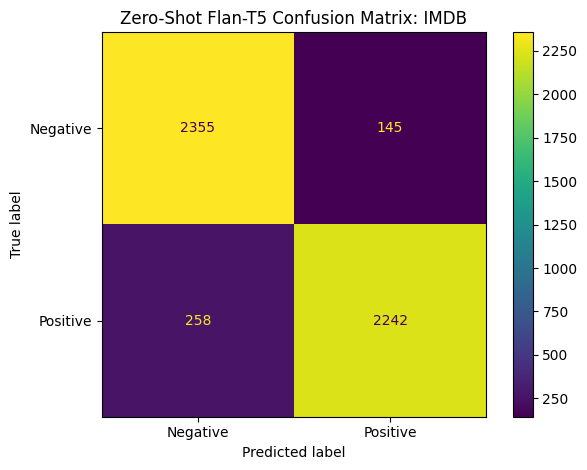

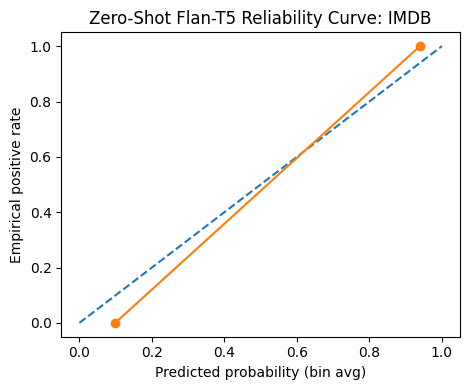


Few-Shot Flan-T5 metrics (IMDB):
Accuracy: 0.921, Macro F1: 0.921, Brier Score: 0.079
              precision    recall  f1-score   support

    Negative       0.92      0.93      0.92      2500
    Positive       0.93      0.91      0.92      2500

    accuracy                           0.92      5000
   macro avg       0.92      0.92      0.92      5000
weighted avg       0.92      0.92      0.92      5000



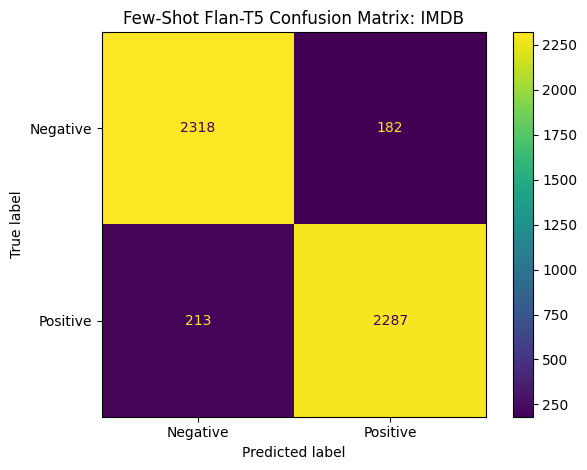

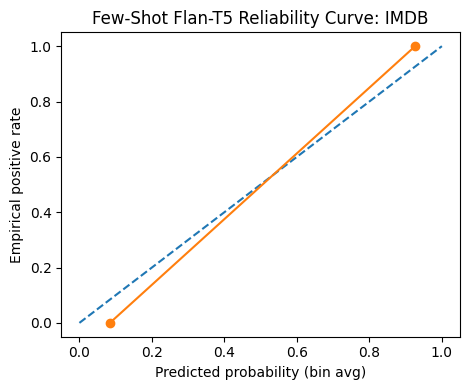


Zero-Shot Flan-T5 metrics (Rotten Tomatoes):
Accuracy: 0.839, Macro F1: 0.839, Brier Score: 0.161
              precision    recall  f1-score   support

    Negative       0.83      0.86      0.84       534
    Positive       0.85      0.82      0.84       533

    accuracy                           0.84      1067
   macro avg       0.84      0.84      0.84      1067
weighted avg       0.84      0.84      0.84      1067



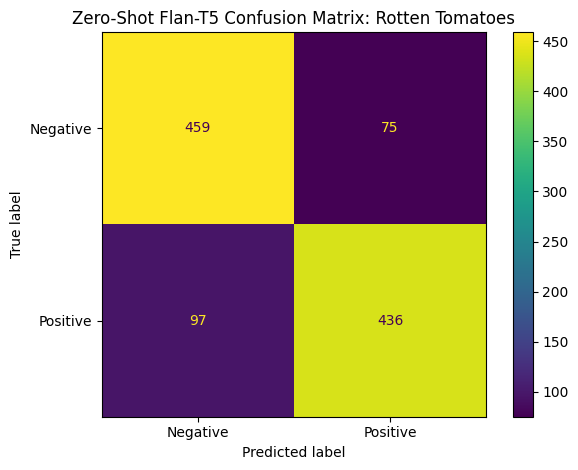

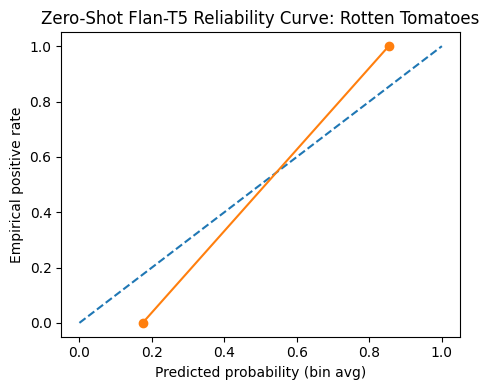


Few-Shot Flan-T5 metrics (Rotten Tomatoes):
Accuracy: 0.848, Macro F1: 0.848, Brier Score: 0.152
              precision    recall  f1-score   support

    Negative       0.84      0.85      0.85       534
    Positive       0.85      0.84      0.85       533

    accuracy                           0.85      1067
   macro avg       0.85      0.85      0.85      1067
weighted avg       0.85      0.85      0.85      1067



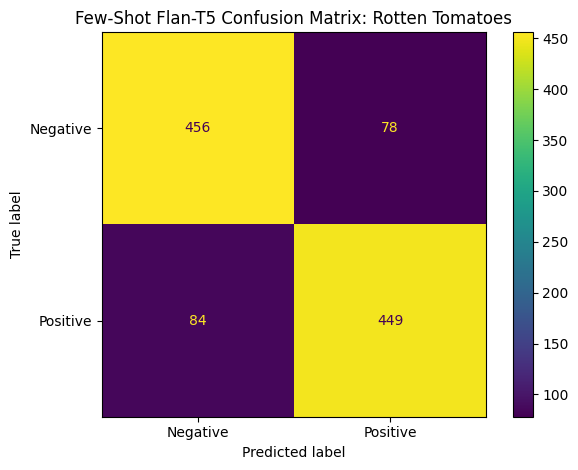

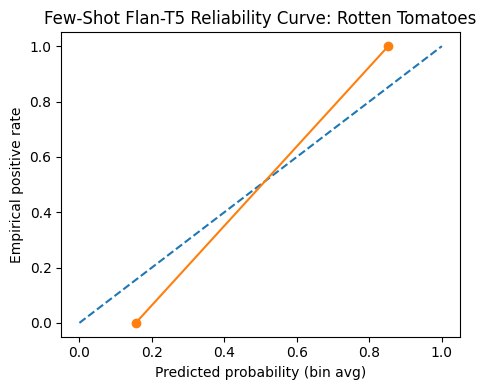

[{'dataset': 'Rotten Tomatoes',
  'model_name': 'Zero-Shot Flan-T5',
  'acc': 0.8388003748828491,
  'macro_f1': 0.8387254385039895,
  'brier': 0.16119962511715089,
  'n_test': 1067},
 {'dataset': 'Rotten Tomatoes',
  'model_name': 'Few-Shot Flan-T5',
  'acc': 0.8481724461105904,
  'macro_f1': 0.8481659112469695,
  'brier': 0.15182755388940955,
  'n_test': 1067}]

In [9]:
label_map = {"Negative": 0, "Positive": 1}

def normalize_labels(preds):
    norm = []
    for p in preds:
        if p.lower() == "positive":
            norm.append("Positive")
        elif p.lower() == "negative":
            norm.append("Negative")
        else:
            # fallback for weird outputs
            norm.append("Negative")
    return norm

def evaluate_and_plot(true_labels, zs_preds, fs_preds, texts, dataset_name="Dataset"):
    """
    true_labels: list of "Positive"/"Negative"
    zs_preds/fs_preds: list of predicted labels
    texts: list of the actual review texts (for JSONL output)
    """
    y_true = [label_map[l] for l in true_labels]
    results = []

    def compute_metrics(name, preds):
        pred_bin = [label_map.get(l, 0) for l in preds]
        prob_pos = [1.0 if l == "Positive" else 0.0 for l in preds]

        acc = accuracy_score(y_true, pred_bin)
        f1m = f1_score(y_true, pred_bin, average="macro")
        brier = brier_score_loss(y_true, prob_pos)

        print(f"\n{name} metrics ({dataset_name}):")
        print(f"Accuracy: {acc:.3f}, Macro F1: {f1m:.3f}, Brier Score: {brier:.3f}")
        print(classification_report(true_labels, preds))

        # Save JSONL predictions (with actual review text)
        rows = [{"text": t, "label": int(y), "pred": int(h), "prob_pos": float(p)}
                for t, y, h, p in zip(texts, y_true, pred_bin, prob_pos)]
        out_path = DIR_PREDS / f"{name.lower().replace('-','_')}_{dataset_name.lower()}_test.jsonl"
        with open(out_path, "w", encoding="utf-8") as f:
            for r in rows:
                f.write(json.dumps(r, ensure_ascii=False) + "\n")

        # Confusion matrix
        cm = confusion_matrix(y_true, pred_bin, labels=[0,1])
        disp = ConfusionMatrixDisplay(cm, display_labels=["Negative","Positive"])
        disp.plot(values_format="d")
        plt.title(f"{name} Confusion Matrix: {dataset_name}")
        cm_path = DIR_FIGS / f"{name.lower().replace('-','_')}_{dataset_name.lower()}_cm.png"
        plt.tight_layout(); plt.savefig(cm_path, dpi=150); plt.show()

        # Reliability curve
        fracs, means = calibration_curve(y_true, prob_pos, n_bins=10, strategy="quantile")
        plt.figure(figsize=(4.8,4))
        plt.plot([0,1],[0,1], linestyle="--")
        plt.plot(fracs, means, marker="o")
        plt.xlabel("Predicted probability (bin avg)")
        plt.ylabel("Empirical positive rate")
        plt.title(f"{name} Reliability Curve: {dataset_name}")
        rel_path = DIR_FIGS / f"{name.lower().replace('-','_')}_{dataset_name.lower()}_reliability.png"
        plt.tight_layout(); plt.savefig(rel_path, dpi=150); plt.show()

        # Append to results summary
        results.append({
            "dataset": dataset_name,
            "model_name": name,
            "acc": acc,
            "macro_f1": f1m,
            "brier": brier,
            "n_test": len(true_labels),
        })

    # Compute metrics for both zero-shot and few-shot
    compute_metrics("Zero-Shot Flan-T5", zs_preds)
    compute_metrics("Few-Shot Flan-T5", fs_preds)

    # Save/append to combined CSV summary
    csv_path = DIR_TABLES / "prompting_metrics.csv"
    file_exists = csv_path.exists()
    with open(csv_path, "a", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=["dataset", "model_name", "acc", "macro_f1", "brier", "n_test"])
        if not file_exists:
            writer.writeheader()
        writer.writerows(results)

    return results



# IMDB
imdb_true_labels = ["Positive" if l == 1 else "Negative" for l in imdb_test["label"]]
evaluate_and_plot(imdb_true_labels, imdb_zs_preds, imdb_fs_preds, texts=imdb_test["text"].tolist(), dataset_name="IMDB")

# Rotten Tomatoes
rt_zs_preds_norm = normalize_labels(rt_zs_preds)
rt_fs_preds_norm = normalize_labels(rt_fs_preds)
rt_true_labels = ["Positive" if l == 1 else "Negative" for l in rt_test["label"]]
evaluate_and_plot(rt_true_labels, rt_zs_preds_norm, rt_fs_preds_norm, texts=rt_test["text"].tolist(), dataset_name="Rotten Tomatoes")